# Python - HW4 - Template

## Zheng Nan Yang

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline
%load_ext sql

C:\Users\AndrewYang\Anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


### Import Data

In [2]:
conn = sqlite3.connect('data/data.db')

Defining parameters

In [3]:
#Parameters
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'

In [4]:
# Parameters
from_date = "2021-11-29"
to_date = "2021-12-13"
token = "ADA"


In [5]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', conn)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [6]:
prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,1.5522,1.6010,1.5522,1.5953,6414677.90,1.013325e+07,ADA,ADA
2021-11-29 01:00:00,1.5952,1.6130,1.5876,1.5996,6456368.98,1.033430e+07,ADA,ADA
2021-11-29 02:00:00,1.5995,1.6137,1.5885,1.6085,3931113.48,6.285606e+06,ADA,ADA
2021-11-29 03:00:00,1.6085,1.6112,1.5910,1.5930,3093837.88,4.943578e+06,ADA,ADA
2021-11-29 04:00:00,1.5930,1.5957,1.5856,1.5925,2364210.88,3.757648e+06,ADA,ADA
...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,1.3578,1.3879,1.3578,1.3693,3922539.26,5.384120e+06,ADA,ADA
2021-12-12 20:00:00,1.3693,1.3779,1.3625,1.3652,2501546.74,3.423638e+06,ADA,ADA
2021-12-12 21:00:00,1.3652,1.3723,1.3631,1.3684,1659459.64,2.271287e+06,ADA,ADA


### Calculate the hourly return by timestamp

In [7]:
prices['log_return'] = np.log(prices['close'] / prices['close'].shift(1))

In [8]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return
ts,,,,,,,,,
2021-11-29 00:00:00,1.5522,1.6010,1.5522,1.5953,6414677.90,1.013325e+07,ADA,ADA,NaN
2021-11-29 01:00:00,1.5952,1.6130,1.5876,1.5996,6456368.98,1.033430e+07,ADA,ADA,0.002692
2021-11-29 02:00:00,1.5995,1.6137,1.5885,1.6085,3931113.48,6.285606e+06,ADA,ADA,0.005548
2021-11-29 03:00:00,1.6085,1.6112,1.5910,1.5930,3093837.88,4.943578e+06,ADA,ADA,-0.009683
2021-11-29 04:00:00,1.5930,1.5957,1.5856,1.5925,2364210.88,3.757648e+06,ADA,ADA,-0.000314
...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,1.3578,1.3879,1.3578,1.3693,3922539.26,5.384120e+06,ADA,ADA,0.008434
2021-12-12 20:00:00,1.3693,1.3779,1.3625,1.3652,2501546.74,3.423638e+06,ADA,ADA,-0.002999
2021-12-12 21:00:00,1.3652,1.3723,1.3631,1.3684,1659459.64,2.271287e+06,ADA,ADA,0.002341


### Calculate the hourly volatility 

In [9]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [10]:
prices['volatility'] = vol_ohlc(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return,volatility
ts,,,,,,,,,,
2021-11-29 00:00:00,1.5522,1.6010,1.5522,1.5953,6414677.90,1.013325e+07,ADA,ADA,NaN,NaN
2021-11-29 01:00:00,1.5952,1.6130,1.5876,1.5996,6456368.98,1.033430e+07,ADA,ADA,0.002692,NaN
2021-11-29 02:00:00,1.5995,1.6137,1.5885,1.6085,3931113.48,6.285606e+06,ADA,ADA,0.005548,NaN
2021-11-29 03:00:00,1.6085,1.6112,1.5910,1.5930,3093837.88,4.943578e+06,ADA,ADA,-0.009683,NaN
2021-11-29 04:00:00,1.5930,1.5957,1.5856,1.5925,2364210.88,3.757648e+06,ADA,ADA,-0.000314,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,1.3578,1.3879,1.3578,1.3693,3922539.26,5.384120e+06,ADA,ADA,0.008434,0.181417
2021-12-12 20:00:00,1.3693,1.3779,1.3625,1.3652,2501546.74,3.423638e+06,ADA,ADA,-0.002999,0.170346
2021-12-12 21:00:00,1.3652,1.3723,1.3631,1.3684,1659459.64,2.271287e+06,ADA,ADA,0.002341,0.164997


### Calculate maximum drawdown up to that hour for each hour

In [11]:
#Max drawdown percentage 
prices['max_drawdown_pct'] = (prices['low'].cummin() - prices['high'].cummax()) / prices['high'].cummax()
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return,volatility,max_drawdown_pct
ts,,,,,,,,,,,
2021-11-29 00:00:00,1.5522,1.6010,1.5522,1.5953,6414677.90,1.013325e+07,ADA,ADA,NaN,NaN,-0.030481
2021-11-29 01:00:00,1.5952,1.6130,1.5876,1.5996,6456368.98,1.033430e+07,ADA,ADA,0.002692,NaN,-0.037694
2021-11-29 02:00:00,1.5995,1.6137,1.5885,1.6085,3931113.48,6.285606e+06,ADA,ADA,0.005548,NaN,-0.038111
2021-11-29 03:00:00,1.6085,1.6112,1.5910,1.5930,3093837.88,4.943578e+06,ADA,ADA,-0.009683,NaN,-0.038111
2021-11-29 04:00:00,1.5930,1.5957,1.5856,1.5925,2364210.88,3.757648e+06,ADA,ADA,-0.000314,NaN,-0.038111
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,1.3578,1.3879,1.3578,1.3693,3922539.26,5.384120e+06,ADA,ADA,0.008434,0.181417,-0.322694
2021-12-12 20:00:00,1.3693,1.3779,1.3625,1.3652,2501546.74,3.423638e+06,ADA,ADA,-0.002999,0.170346,-0.322694
2021-12-12 21:00:00,1.3652,1.3723,1.3631,1.3684,1659459.64,2.271287e+06,ADA,ADA,0.002341,0.164997,-0.322694


### Plotting

plot in a 2x2 grid:
* hourly return
* hourly vol
* maximum drawdown
* close prices
* color each day on the graph

In [12]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.terrain(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [13]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

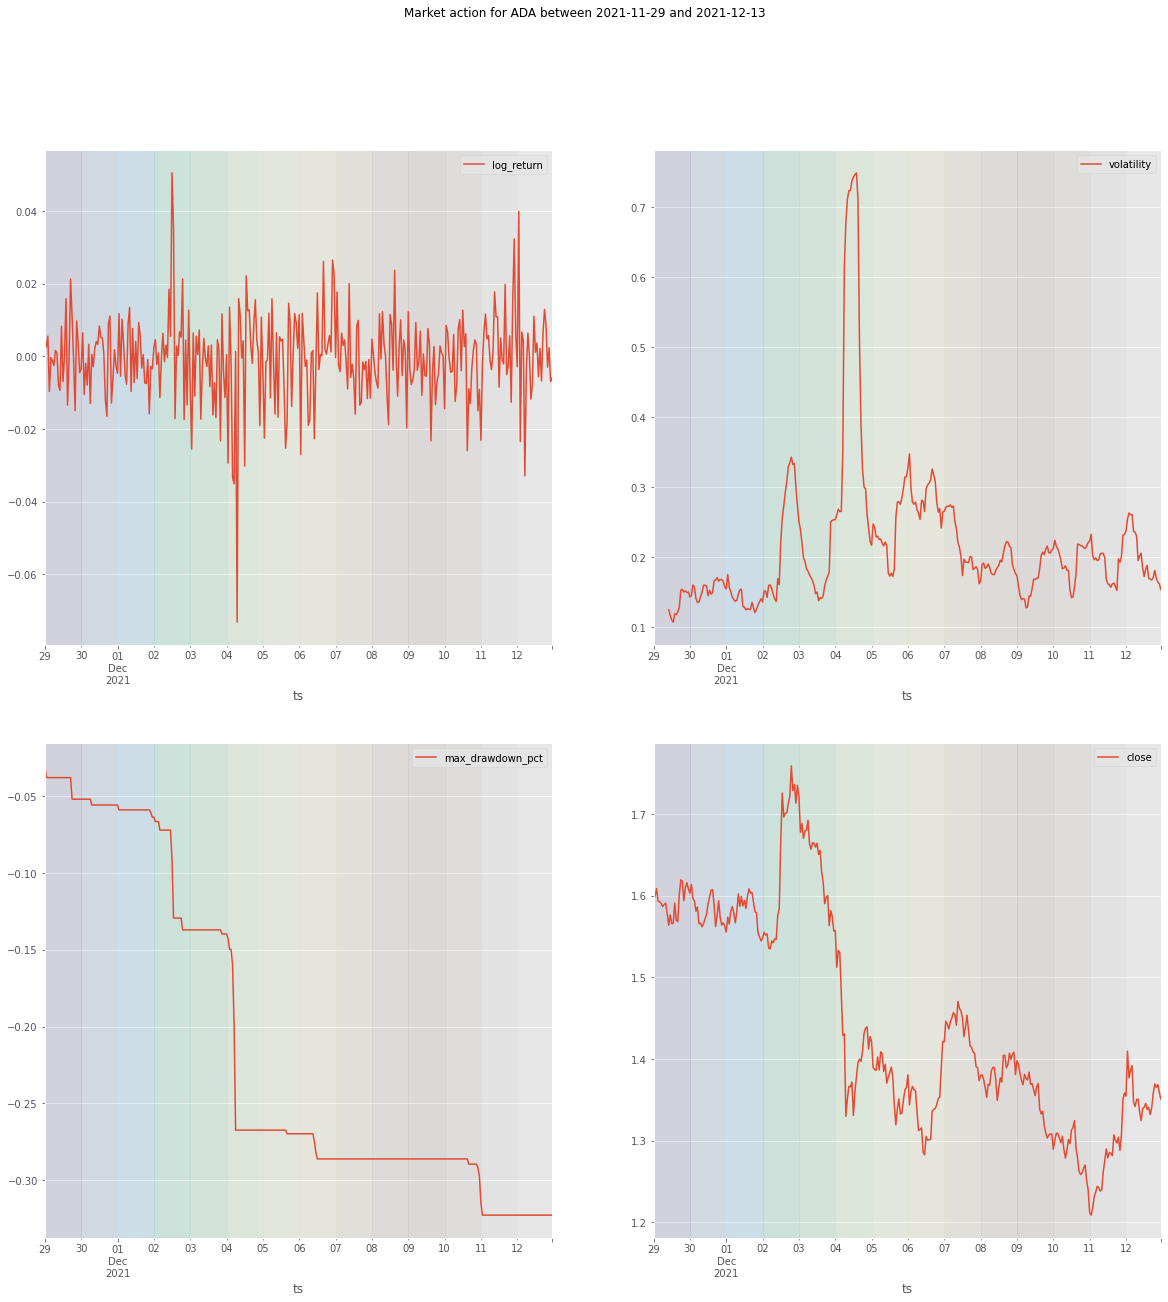

In [14]:
series_plot(prices[['log_return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown_pct']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

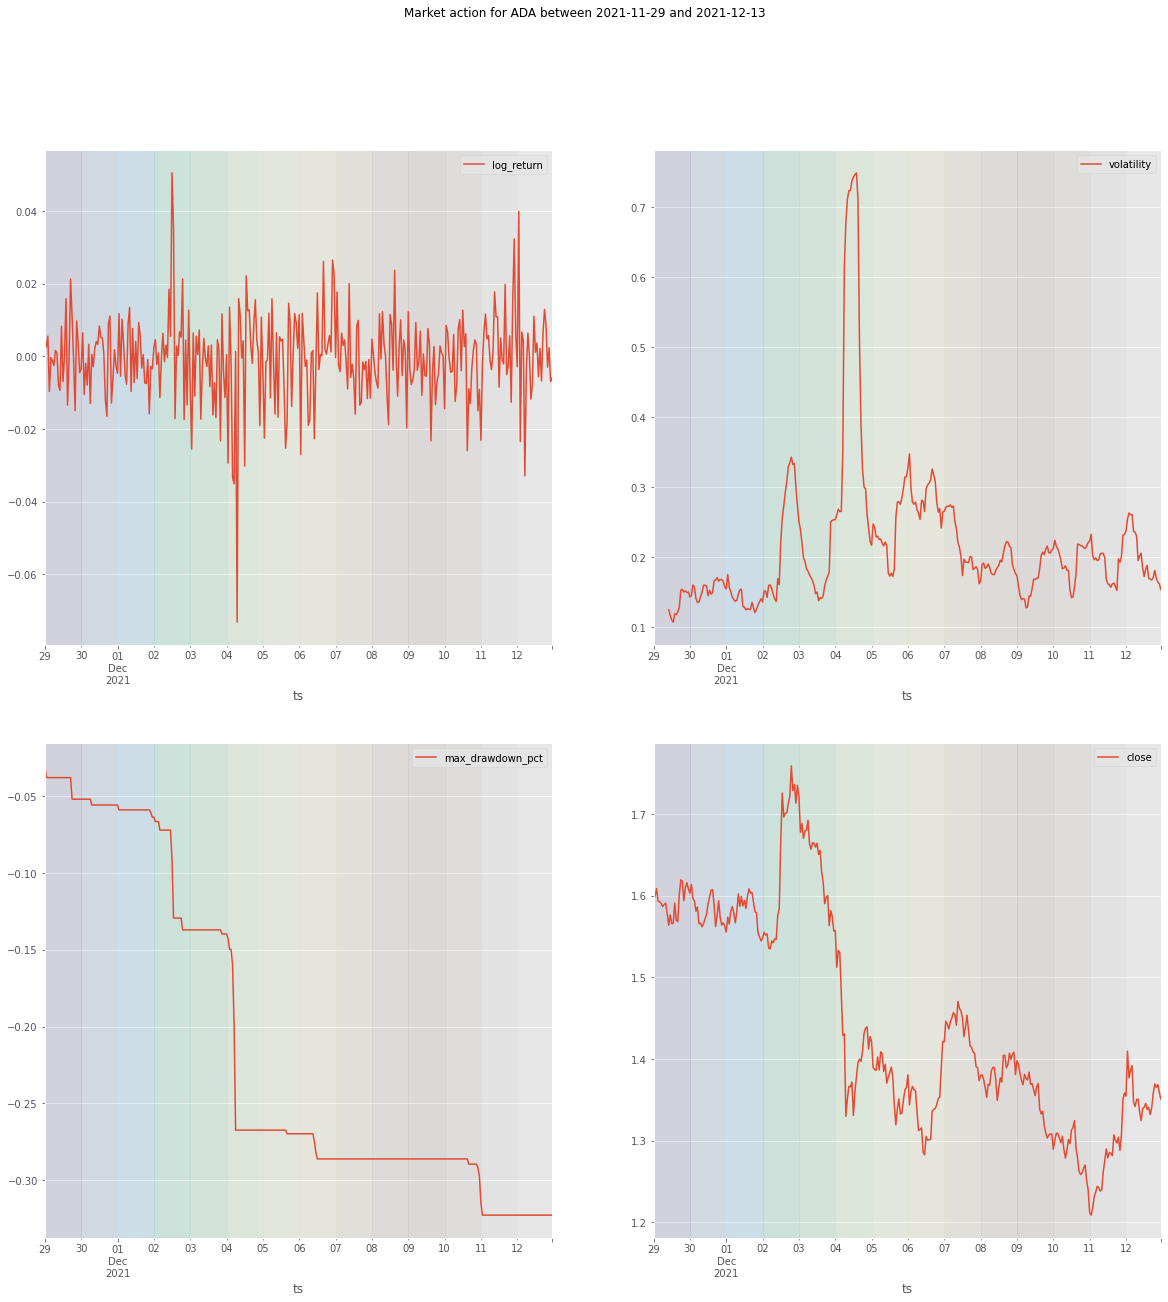

In [15]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)